In [ ]:
Da untere 2 Auskommentierte Code Teile sind die Bilder von einem Open-Data Source Bilder runterzuladen. Da die Bilder in unserer
lokalen Rechnern runtergeladen haben, wurde diese Teile auskommentiert.

In [ ]:
"""import urllib.request
import tarfile
import os

# URLs für die zu ladenden .gz-Dateien
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
]

# Zielverzeichnis für extrahierte Dateien
extract_dir = 'images'

# Überprüfe, ob das Zielverzeichnis existiert, andernfalls erstelle es
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Schleife zum Herunterladen und Extrahieren jeder Datei
for idx, link in enumerate(links):
    # Erstelle den Dateinamen basierend auf der Indexnummer
    compressed_file = f'images_{idx + 1:02d}.gz'

    # Herunterladen der Datei
    print(f'Downloading {compressed_file}...')
    urllib.request.urlretrieve(link, compressed_file)
    print("Download complete. Please check the checksum.")

    # Extrahieren der Datei
    print(f'Extracting {compressed_file}...')
    with tarfile.open(compressed_file, 'r:gz') as tar:
        tar.extractall(path=extract_dir)
    print(f"Extraction complete. Files are saved in '{extract_dir}'.")

    # Lösche die .gz-Datei nach der Extraktion (optional)
    os.remove(compressed_file)
    print(f"Deleted {compressed_file} after extraction.")

print("Processing complete.")"""

In [ ]:
"""import os
import numpy as np
from PIL import Image

# Verzeichnis mit den extrahierten Bildern
extract_dir = 'images'

# Erwartete Bildauflösung
expected_resolution = (1024, 1024)

# Akzeptierte Hounsfield-Werte (CT-Bereich)
hounsfield_range = (-1024, 3071)

# Zähler für Abweichungen
resolution_mismatch_count = 0
hounsfield_mismatch_count = 0

# Funktion zur Überprüfung der Bildauflösung
def check_resolution(image, expected_resolution):
    return image.size == expected_resolution

# Funktion zur Überprüfung der Hounsfield-Werte
def check_hounsfield_values(image_array, hounsfield_range):
    min_val, max_val = hounsfield_range
    return np.min(image_array) >= min_val and np.max(image_array) <= max_val

# Normierungsprüfung
print("Starting normalization checks...")

# Durchlaufe alle Dateien im Verzeichnis
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        file_path = os.path.join(root, file)

        # Stelle sicher, dass die Datei ein Bild ist, z.B. mit .png, .jpg oder .dcm
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm')):  # Du kannst hier die gewünschten Formate anpassen
            try:
                # Lade das Bild
                img = Image.open(file_path)
                img_array = np.array(img)

                # Auflösung prüfen
                if not check_resolution(img, expected_resolution):
                    resolution_mismatch_count += 1
                    print(f"Resolution mismatch in {file}: {img.size}")

                # Hounsfield-Werte prüfen
                if not check_hounsfield_values(img_array, hounsfield_range):
                    hounsfield_mismatch_count += 1
                    print(f"Hounsfield value out of range in {file}: Min={np.min(img_array)}, Max={np.max(img_array)}")

            except Exception as e:
                print(f"Error processing {file}: {e}")

# Ausgabe der Gesamtzahl der Abweichungen
print(f"\nTotal images with resolution mismatch: {resolution_mismatch_count}")
print(f"Total images with Hounsfield value mismatch: {hounsfield_mismatch_count}")
print("Normalization checks complete.") """

In [1]:
#Zuerst füge ich die benötigte Bibliotheken dazu, die genutzte Funktionen gehören.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,Input,Concatenate,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import regularizers

2025-03-07 09:40:30.697129: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 09:40:30.783262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 09:40:30.834506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741336830.887616    5314 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741336830.902127    5314 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 09:40:31.043860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
"""Konstanten für dei Datenverarbeitung hinzugefügt. Wo die Bilder im lokalen Rechner gespeichert wird, welche Data als Klassifizierung 
von Bilder genutzt wird. Image Size werden in dem EfficientNet Modelle als 224 Pixel benutzt, deswegen habe ich hier es auch 224 Pixels begrenzt.
Batch Size wird meistens als 32 angenommen, Bei manche Fälle 16, 64 sogar 128 ist auch möglich."""

'Konstanten für dei Datenverarbeitung hinzugefügt. Wo die Bilder im lokalen Rechner gespeichert wird, welche Data als Klassifizierung \nvon Bilder genutzt wird. Image Size werden in dem EfficientNet Modelle als 224 Pixel benutzt, deswegen habe ich hier es auch 224 Pixels begrenzt.\nBatch Size wird meistens als 32 angenommen, Bei manche Fälle 16, 64 sogar 128 ist auch möglich.'

In [3]:
# Datenverzeichnis und CSV-Datei
DATA_DIR = 'images2/images'
CSV_FILE = 'Data_Entry_2017_v2020.csv'
IMG_SIZE = 224
BATCH_SIZE = 32


In [4]:
# CSV-Datei einlesen
data = pd.read_csv(CSV_FILE)

# Bildpfade mit Unterordnern
data['image_path'] = data['Image Index'].apply(
    lambda x: os.path.join("images2/images", x)  # Direkter Pfad ohne Unterordner
)
# Nur Bilder behalten, die wirklich existieren
existing_images = set(os.listdir(DATA_DIR))
data = data[data['Image Index'].isin(existing_images)]

# One-Hot-Encoding mit MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(data['Finding Labels'].str.split('|'))
all_diseases = mlb.classes_.tolist()

# Datenverteilung (sortiert)
disease_counts = label_matrix.sum(axis=0)
sorted_indices = np.argsort(-disease_counts)
print("\nKrankheitsverteilung (absteigend):")
for idx in sorted_indices:
    disease = all_diseases[idx]
    count = disease_counts[idx]
    percentage = (count / len(label_matrix)) * 100
    print(f"{disease}: {count} ({percentage:.2f}%)")


Krankheitsverteilung (absteigend):
No Finding: 20353 (58.15%)
Infiltration: 5048 (14.42%)
Effusion: 3370 (9.63%)
Atelectasis: 3345 (9.56%)
Nodule: 1803 (5.15%)
Pneumothorax: 1406 (4.02%)
Mass: 1332 (3.81%)
Consolidation: 1241 (3.55%)
Pleural_Thickening: 1018 (2.91%)
Cardiomegaly: 994 (2.84%)
Emphysema: 726 (2.07%)
Fibrosis: 721 (2.06%)
Edema: 497 (1.42%)
Pneumonia: 386 (1.10%)
Hernia: 87 (0.25%)


In [5]:
print("Beispielpfade aus dem DataFrame:")
print(data['image_path'].head(5).tolist())

# Prüfe, ob die Bilder existieren
for path in data['image_path'].head(5):
    print(f"Existiert {path}? → {os.path.exists(path)}")

Beispielpfade aus dem DataFrame:
['images2/images/00000001_000.png', 'images2/images/00000001_001.png', 'images2/images/00000001_002.png', 'images2/images/00000002_000.png', 'images2/images/00000003_001.png']
Existiert images2/images/00000001_000.png? → True
Existiert images2/images/00000001_001.png? → True
Existiert images2/images/00000001_002.png? → True
Existiert images2/images/00000002_000.png? → True
Existiert images2/images/00000003_001.png? → True


In [6]:
### Berechnung der Gewichte für unbalancierte Klassen
def calculate_class_weights(label_matrix):
    label_matrix = np.array(label_matrix)  # Falls DataFrame
    total_samples = label_matrix.shape[0]
    pos_counts = np.sum(label_matrix, axis=0)

    # Positivgewichte: Skalierung über sqrt zur besseren Verteilung
    pos_weights = np.sqrt(total_samples / (2 * pos_counts + 1))
    pos_weights = np.clip(pos_weights, 1.0, 10.0)  # Reduziere max. auf 10 für Stabilität

    # Negativgewichte: Sanfte Abstufung für seltene Klassen
    neg_weights = np.exp(-pos_counts / total_samples) + 0.3
    neg_weights = np.clip(neg_weights, 0.2, 1.0)

    return pos_weights, neg_weights

# Funktionsaufruf
pos_weights, neg_weights = calculate_class_weights(label_matrix)
print("Positivgewichte:", pos_weights)
print("Negativgewichte:", neg_weights)

Positivgewichte: [ 2.28708499  4.19479195  3.75439064  5.93084095  2.2785872   4.90789215
  4.92486865 10.          1.86179406  3.62392508  1.          3.1149763
  4.14507414  6.72880699  3.52730449]
Negativgewichte: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.85904187 1.
 1.         1.         1.        ]


In [7]:
def focal_loss_with_weights(alpha, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)  # Numerische Stabilität
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        # Focal Loss Skalar berechnen
        focal_weight = alpha * (1 - y_pred) ** gamma * y_true + (y_pred ** gamma) * (1 - y_true)
        return tf.reduce_mean(bce * focal_weight)

    return loss


In [8]:
# loss function to handle the weights better
def weighted_binary_crossentropy(pos_weights, neg_weights):
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)
    neg_weights = tf.constant(neg_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Manuelle BCE-Berechnung zur Erhaltung der Klassen-Dimension
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Numerische Stabilität
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))  # Shape: (batch, 15)
        
        # Gewichte anpassen
        class_weights = y_true * pos_weights + (1 - y_true) * neg_weights
        
        # Gewichteten Verlust berechnen und mitteln
        weighted_loss = tf.reduce_mean(bce * class_weights)
        return weighted_loss
    
    return loss

In [9]:
from sklearn.model_selection import GroupShuffleSplit

# Füge Multi-Hot-Encoded-Spalten zum DataFrame hinzu
data[all_diseases] = label_matrix.astype(int)

# Train/Validation-Split mit Patientengruppen
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(data, groups=data['Patient ID']))
train_data, val_data = data.iloc[train_idx], data.iloc[val_idx]


In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.95, 1.05],  # Keine großen Vergrößerungen
    brightness_range=[0.98, 1.02],  # Minimale Helligkeitsänderung
    channel_shift_range=10  # Simuliert Röntgen-Kontrastvariation
)

val_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
   # horizontal_flip=True  # Nur für Validation!
)


In [11]:
print("Beispielpfade aus dem DataFrame:")
print(train_data['image_path'].head(5).tolist())

Beispielpfade aus dem DataFrame:
['images2/images/00000002_000.png', 'images2/images/00000003_001.png', 'images2/images/00000003_002.png', 'images2/images/00000003_003.png', 'images2/images/00000003_004.png']


In [12]:
import os
for path in train_data['image_path'].head(5):
    print(f"Existiert {path}? → {os.path.exists(path)}")

Existiert images2/images/00000002_000.png? → True
Existiert images2/images/00000003_001.png? → True
Existiert images2/images/00000003_002.png? → True
Existiert images2/images/00000003_003.png? → True
Existiert images2/images/00000003_004.png? → True


In [13]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col=all_diseases,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=BATCH_SIZE
)

# Validation Data Generator (OHNE Augmentierung)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col=all_diseases,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False  # Wichtig für konsistente Evaluation
)

Found 27669 validated image filenames.
Found 7330 validated image filenames.


In [14]:
print("\nKlassenverteilung im Training:")
print(train_data[all_diseases].sum())
print("\nKlassenverteilung in Validation:")
print(val_data[all_diseases].sum())


Klassenverteilung im Training:
Atelectasis            2632
Cardiomegaly            770
Consolidation           964
Edema                   395
Effusion               2629
Emphysema               578
Fibrosis                566
Hernia                   74
Infiltration           3952
Mass                   1011
No Finding            16173
Nodule                 1380
Pleural_Thickening      818
Pneumonia               303
Pneumothorax           1061
dtype: int64

Klassenverteilung in Validation:
Atelectasis            713
Cardiomegaly           224
Consolidation          277
Edema                  102
Effusion               741
Emphysema              148
Fibrosis               155
Hernia                  13
Infiltration          1096
Mass                   321
No Finding            4180
Nodule                 423
Pleural_Thickening     200
Pneumonia               83
Pneumothorax           345
dtype: int64


In [15]:
train_ids = set(train_data['Patient ID'])
val_ids = set(val_data['Patient ID'])
print(f"Overlap: {len(train_ids & val_ids)}")  # Muss 0 sein!

Overlap: 0


In [16]:
print(data[['Finding Labels', 'Patient ID']].sample(5))

      Finding Labels  Patient ID
4328      No Finding        1170
8140    Infiltration        2135
9603      No Finding        2492
13987     No Finding        3610
29446     No Finding        7670


In [17]:
from tensorflow.keras.applications.efficientnet import preprocess_input  # Wichtig!

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)  # Konvertierung zu RGB
x = Lambda(lambda x: x * 255.0)(x)  # Skalierung auf 0-255
x = Lambda(preprocess_input)(x)  # EfficientNet-spezifische Normalisierung

In [18]:
from tensorflow.keras.applications import ResNet50

def build_model(model_name, img_size=224):
    inputs = Input(shape=(img_size, img_size, 1))
    
    # Verbesserte Konvertierung von Graustufen zu RGB
    x = Lambda(lambda img: tf.repeat(img, repeats=3, axis=-1))(inputs)
    
    # Modellspezifische Preprocessing mit besserer Fehlerbehandlung
    try:
        if model_name == "EfficientNetB0":
            x = Lambda(lambda x: x * 255.0)(x)
            x = Lambda(tf.keras.applications.efficientnet.preprocess_input)(x)
            base_model = EfficientNetB0(
                include_top=False, 
                weights='imagenet', 
                input_tensor=x, 
                pooling='avg'
            )
        elif model_name == "ResNet50":
            x = Lambda(tf.keras.applications.resnet.preprocess_input)(x)
            base_model = ResNet50(
                include_top=False, 
                weights='imagenet', 
                input_tensor=x, 
                pooling='avg'
            )
       
        else:
            raise ValueError(f"Nicht unterstütztes Modell: {model_name}")
    except Exception as e:
        print(f"Fehler bei der Modellinitialisierung für {model_name}: {e}")
        raise
    
    # Transfer Learning Einstellungen mit flexiblerer Konfiguration
    base_model.trainable = True
    freeze_layers = {
        "EfficientNetB0": 150,
        "ResNet50": 100
    }
    
    for layer in base_model.layers[:freeze_layers.get(model_name, 0)]:
        layer.trainable = False
    
    # Top Layers mit zusätzlicher Flexibilität
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(all_diseases), activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    # Lernraten pro Modell
    learning_rates = {
        "EfficientNetB0": 5e-5,
        "ResNet50": 1e-4
    }
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rates.get(model_name, 1e-4)),
        loss=weighted_binary_crossentropy(pos_weights, neg_weights),
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

In [19]:
models_to_train = ["EfficientNetB0", "ResNet50"]
histories = {}

for model_name in models_to_train:
    try:
        print(f"\n=== Training {model_name} ===")
        
        # Modell erstellen
        model = build_model(model_name)
        
        # Early Stopping mit verbesserten Parametern
        early_stop = EarlyStopping(
            monitor='val_auc',
            patience=5,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        
        # Training mit zusätzlicher Fehlerbehandlung
        try:
            history = model.fit(
                train_generator,
                validation_data=val_generator,
                epochs=50,
                callbacks=[early_stop],
                verbose=2
            )
            
            histories[model_name] = history.history
            model.save(f"{model_name}_xray_model.keras")
        except Exception as training_error:
            print(f"Trainingsfehler für {model_name}: {training_error}")
            continue
    
    except Exception as model_error:
        print(f"Modellerstellungsfehler für {model_name}: {model_error}")
        continue



=== Training EfficientNetB0 ===


W0000 00:00:1741336843.334009    5314 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/cakir/jupyter_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
865/865 - 869s - 1s/step - auc: 0.6973 - loss: 0.8178 - val_auc: 0.8373 - val_loss: 0.6333
Epoch 2/50
865/865 - 838s - 968ms/step - auc: 0.8002 - loss: 0.6544 - val_auc: 0.8598 - val_loss: 0.6026
Epoch 3/50
865/865 - 837s - 968ms/step - auc: 0.8301 - loss: 0.6080 - val_auc: 0.8688 - val_loss: 0.5751
Epoch 4/50
865/865 - 838s - 968ms/step - auc: 0.8482 - loss: 0.5739 - val_auc: 0.8773 - val_loss: 0.5493
Epoch 5/50
865/865 - 837s - 968ms/step - auc: 0.8620 - loss: 0.5423 - val_auc: 0.8814 - val_loss: 0.5264
Epoch 6/50
865/865 - 838s - 969ms/step - auc: 0.8699 - loss: 0.5172 - val_auc: 0.8848 - val_loss: 0.5065
Epoch 7/50
865/865 - 837s - 968ms/step - auc: 0.8768 - loss: 0.4941 - val_auc: 0.8854 - val_loss: 0.4899
Epoch 8/50
865/865 - 836s - 967ms/step - auc: 0.8834 - loss: 0.4718 - val_auc: 0.8847 - val_loss: 0.4749
Epoch 9/50
865/865 - 835s - 965ms/step - auc: 0.8881 - loss: 0.4526 - val_auc: 0.8851 - val_loss: 0.4638
Epoch 10/50
865/865 - 837s - 968ms/step - auc: 0.8939 - lo

In [20]:
# Modellausgabe
model.build((None, 224, 224, 1))
print(model.output.shape)  # Sollte (None, 15) sein

# Generator Check
batch = next(iter(train_generator))
print("Label shape:", batch[1].shape)  # Muss (32, 15) sein

(None, 15)
Label shape: (32, 15)


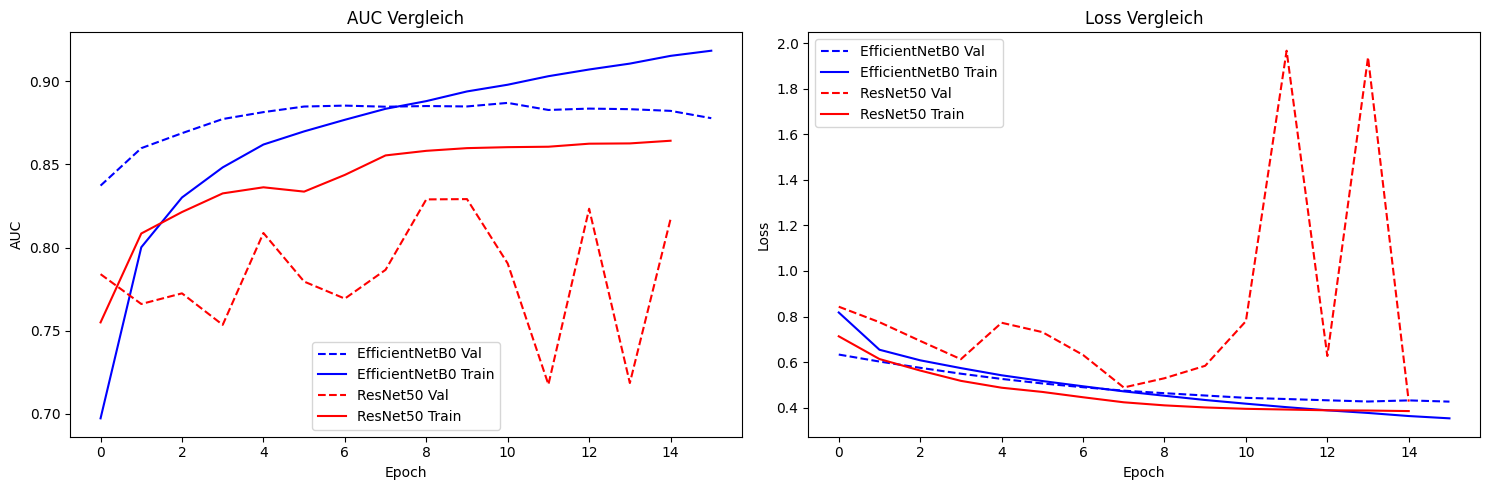

In [21]:
plt.figure(figsize=(15, 5))
colors = {'EfficientNetB0':'blue', 'ResNet50':'red'}

# Validation AUC
plt.subplot(1, 2, 1)
for model_name, hist in histories.items():
    plt.plot(hist['val_auc'], color=colors[model_name], linestyle='--', label=f'{model_name} Val')
    plt.plot(hist['auc'], color=colors[model_name], label=f'{model_name} Train')
plt.title('AUC Vergleich')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
for model_name, hist in histories.items():
    plt.plot(hist['val_loss'], color=colors[model_name], linestyle='--', label=f'{model_name} Val')
    plt.plot(hist['loss'], color=colors[model_name], label=f'{model_name} Train')
plt.title('Loss Vergleich')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ConvNeXtTiny

BATCH_SIZE = 8

def convnext_preprocess(x):
    mean = tf.constant([0.485, 0.456, 0.406], dtype=x.dtype)
    std = tf.constant([0.229, 0.224, 0.225], dtype=x.dtype)
    return (x - mean) / std

def build_model(model_name, img_size=224):
    # Eingabeschicht definieren
    inputs = Input(shape=(img_size, img_size, 3))
    
    # Skalierung und Normalisierung
    x = Lambda(lambda x: x / 255.0)(inputs)
    x = Lambda(convnext_preprocess)(x)
    
    # Basismodell ohne Top-Schichten laden
    base_model = ConvNeXtTiny(
        include_top=False, 
        weights='imagenet', 
        input_shape=(img_size, img_size, 3),
        pooling='avg'
    )
    
    # Basismodell auf die Eingaben anwenden
    x = base_model(x)
    
    # Basismodell-Schichten einfrieren
    base_model.trainable = True
    freeze_layers = {
        "ConvNeXt": 150
    }
    for layer in base_model.layers[:freeze_layers.get(model_name, 0)]:
        layer.trainable = False
    
    # Zusätzliche Schichten hinzufügen
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(all_diseases), activation='sigmoid')(x)
    
    # Modell erstellen
    model = Model(inputs, outputs)
    
    # Lernrate festlegen
    learning_rates = {
        "ConvNeXt": 1e-4
    }
    
    # Modell kompilieren
    model.compile(
        optimizer=Adam(learning_rate=learning_rates.get(model_name, 1e-4)),
        loss=weighted_binary_crossentropy(pos_weights, neg_weights),
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

models_to_train = [ "ConvNeXt"]
histories = {}

for model_name in models_to_train:
    try:
        print(f"\n=== Training {model_name} ===")
        
        # Modell erstellen
        model = build_model(model_name)
        
        # Early Stopping mit verbesserten Parametern
        early_stop = EarlyStopping(
            monitor='val_auc',
            patience=5 if model_name == "ConvNeXt" else 7,
            mode='max',
            restore_best_weights=True,
            verbose=1
        )
        
        # Training mit zusätzlicher Fehlerbehandlung
        try:
            history = model.fit(
                train_generator,
                validation_data=val_generator,
                epochs=50,
                callbacks=[early_stop],
                verbose=2
            )
            
            histories[model_name] = history.history
            model.save(f"{model_name}_xray_model.keras")
        except Exception as training_error:
            print(f"Trainingsfehler für {model_name}: {training_error}")
            continue
    
    except Exception as model_error:
        print(f"Modellerstellungsfehler für {model_name}: {model_error}")
        continue



In [ ]:
plt.figure(figsize=(15, 5))
colors = {'ConvNeXt':'green'}

# Validation AUC
plt.subplot(1, 2, 1)
for model_name, hist in histories.items():
    plt.plot(hist['val_auc'], color=colors[model_name], linestyle='--', label=f'{model_name} Val')
    plt.plot(hist['auc'], color=colors[model_name], label=f'{model_name} Train')
plt.title('AUC Vergleich')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
for model_name, hist in histories.items():
    plt.plot(hist['val_loss'], color=colors[model_name], linestyle='--', label=f'{model_name} Val')
    plt.plot(hist['loss'], color=colors[model_name], label=f'{model_name} Train')
plt.title('Loss Vergleich')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
import numpy as np

def convert_grayscale_to_rgb(image):
    """ Konvertiert ein Graustufenbild (224, 224, 1) zu RGB (224, 224, 3) """
    return np.concatenate([image] * 3, axis=-1)

# Beispiel mit einem Tensor (Batch von Bildern)
x_gray = np.random.rand(1, 224, 224, 1)  # Dummy-Bild in Graustufen
x_rgb = convert_grayscale_to_rgb(x_gray)
print(x_rgb.shape)  # Sollte (1, 224, 224, 3) sein


(1, 224, 224, 3)
